# Project 02 - Data Representations and Clustering

-   Date: Feb 12th
-   Group Members: 
  - Guanyu Qian (UID: 606076335) 
  - Hanyi Duan (UID: 806073864)
  - Yifan Zhong (UID: 705507868)




In [ ]:
############## Q1
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


############## Q2&3 
from sklearn.cluster import KMeans
from sklearn.metrics.cluster  import (
    contingency_matrix, 
    homogeneity_score, 
    completeness_score, 
    v_measure_score, 
    adjusted_rand_score, 
    adjusted_mutual_info_score

)

############## Q4-9
from sklearn.decomposition import NMF, TruncatedSVD
from plotmat import plot_mat
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10,5) # adjust fig size *for all figs*

############## Q10
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix


############## Q11-13
!pip install umap-learn
from umap import UMAP

############## Q14
from sklearn.cluster import AgglomerativeClustering

############## Q15&16
!pip install hdbscan
from hdbscan import HDBSCAN

############## Q17&18
import pickle

############## Q19-25
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from sklearn.manifold import TSNE
from sklearn.base import BaseEstimator
from sklearn.datasets import make_blobs

from tqdm import tqdm
import requests
import os
import tarfile

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# define helper function to print five clustering evaluation metrics
def print_eval_metrics(process, true_labels, predicted_labels):
  homogeneity = homogeneity_score(true_labels, predicted_labels)
  completeness = completeness_score(true_labels, predicted_labels)
  v_measure = v_measure_score(true_labels, predicted_labels)
  adjusted_rand = adjusted_rand_score(true_labels, predicted_labels)
  adjusted_mutual_info = adjusted_mutual_info_score(true_labels, predicted_labels)
  
  print('#' * 20)
  print("Homogeneity score in {0} transform is: {1}".format(process, homogeneity))
  print("Completeness score in {0} transform is: {1}".format(process, completeness))
  print("V-measure score in {0} transform is: {1}".format(process, v_measure))
  print("Adjusted rand score in {0} transform is: {1}".format(process, adjusted_rand))
  print("Adjusted mutual info score in {0} transform is: {1}".format(process, adjusted_mutual_info))
  print('#' * 20)

In [ ]:
newsgroups_data = fetch_20newsgroups()
newsgroups_data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

# Clustering with Sparse Text Representations

In [ ]:
c1 = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']

c2 = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

categories = c1 + c2

newsgroups_data = fetch_20newsgroups(categories = categories, 
                                     remove = ('headers', 'footers'))


In [ ]:
# TF-IDF transform

tfidfvector = TfidfVectorizer(min_df=3, stop_words='english')

X_tfidf = tfidfvector.fit_transform(newsgroups_data.data)

print("Dimensions of the TF-IDF is :", X_tfidf.shape)

Dimensions of the TF-IDF is : (4732, 17131)


In [ ]:
kmeans = KMeans(n_clusters=2, max_iter = 2000, n_init = 60, random_state=0)

# predicted label
kmeans_label = kmeans.fit_predict(X_tfidf) 

In [ ]:
# true label generation 

target_names = newsgroups_data.target_names

label = newsgroups_data.target

category_name=[]
for i in label:
  category_name.append(target_names[i])

binary_label=[]
for i in category_name:
  #c refers to comp, which is in computer class
  if i[0] == "c":
    binary_label.append(0)
  #else refers to rec, which is in recreation class
  else:
    binary_label.append(1)

#important: 0 is comp (Class1) and 1 is rec (Class2)

Contingency table of the clustering result: 
 [[1940  403]
 [  45 2344]]


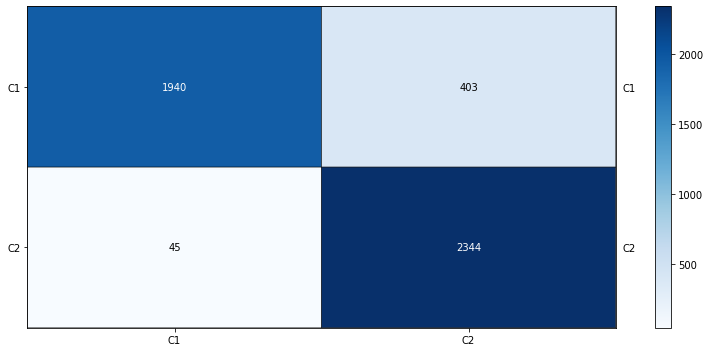

In [ ]:
cont_mx = contingency_matrix(binary_label, kmeans_label)

print("Contingency table of the clustering result: \n", cont_mx)


rows, cols = linear_sum_assignment(cont_mx, maximize=True)

x = ["C1" if i == 0 else "C2" for i in rows]

y = ["C1" if i == 0 else "C2" for i in cols]

plot_mat(cont_mx[rows[:, np.newaxis], cols], xticklabels = x, yticklabels = y, size=(10,5))


#plot_mat(cont_mx,  xticklabels = ['C1','C2'], yticklabels = ['C1','C2'], size=(10,5))

In [ ]:
# 5 clustering measures: K-means
print_eval_metrics("TI-IDF", binary_label, kmeans_label)

####################
Homogeneity score in TI-IDF transform is: 0.5852566172247848
Completeness score in TI-IDF transform is: 0.5964216999698374
V-measure score in TI-IDF transform is: 0.5907864119779943
Adjusted rand score in TI-IDF transform is: 0.6570834245592161
Adjusted mutual info score in TI-IDF transform is: 0.5907234072569751
####################


# Clustering with Dense Text Representations

## Generate dense representations for better K-Means Clustering

Text(0, 0.5, 'Explained variance ratio ')

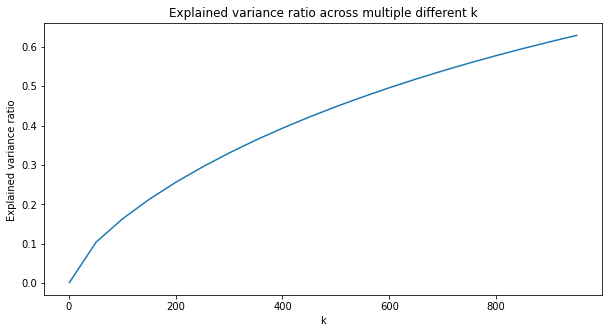

In [ ]:
##### running time around 3 mins

# SVD transform
k = np.arange(1, 1000, 50)

variance_ratio_sum=[]
for i in k:
    svd = TruncatedSVD(n_components=i, random_state=0)
    X_svd = svd.fit_transform(X_tfidf)
    variance_ratio = svd.explained_variance_ratio_.sum()
    variance_ratio_sum.append(variance_ratio)

plt.plot(k,variance_ratio_sum)

plt.title('Explained variance ratio across multiple different k')
plt.xlabel('k')
plt.ylabel('Explained variance ratio ')

In [ ]:
##### running time around 1 min
k = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]


h_svd = []

c_svd = []

v_svd = []

adj_r_svd = []

adj_mi_svd= []


for i in k:
    svd = TruncatedSVD(n_components=i, random_state=0)

    X_svd = svd.fit_transform(X_tfidf)

    kmeans_label_svd = kmeans.fit_predict(X_svd)

    h_svd.append(homogeneity_score(binary_label, kmeans_label_svd)) 

    c_svd.append(completeness_score(binary_label, kmeans_label_svd))

    v_svd.append(v_measure_score(binary_label, kmeans_label_svd))

    adj_r_svd.append(adjusted_rand_score(binary_label, kmeans_label_svd))

    adj_mi_svd.append(adjusted_mutual_info_score(binary_label, kmeans_label_svd))


In [ ]:
##### running time around 15 mins

k = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]


h_nmf = []

c_nmf = []

v_nmf = []

adj_r_nmf = []

adj_mi_nmf= []


for i in k:

    nmf = NMF(n_components=i, init = 'random', random_state=0, max_iter=500) 

    X_nmf = nmf.fit_transform(X_tfidf)

    kmeans_label_nmf = kmeans.fit_predict(X_nmf)

    h_nmf.append(homogeneity_score(binary_label, kmeans_label_nmf)) 

    c_nmf.append(completeness_score(binary_label, kmeans_label_nmf))

    v_nmf.append(v_measure_score(binary_label, kmeans_label_nmf))

    adj_r_nmf.append(adjusted_rand_score(binary_label, kmeans_label_nmf))

    adj_mi_nmf.append(adjusted_mutual_info_score(binary_label, kmeans_label_nmf))

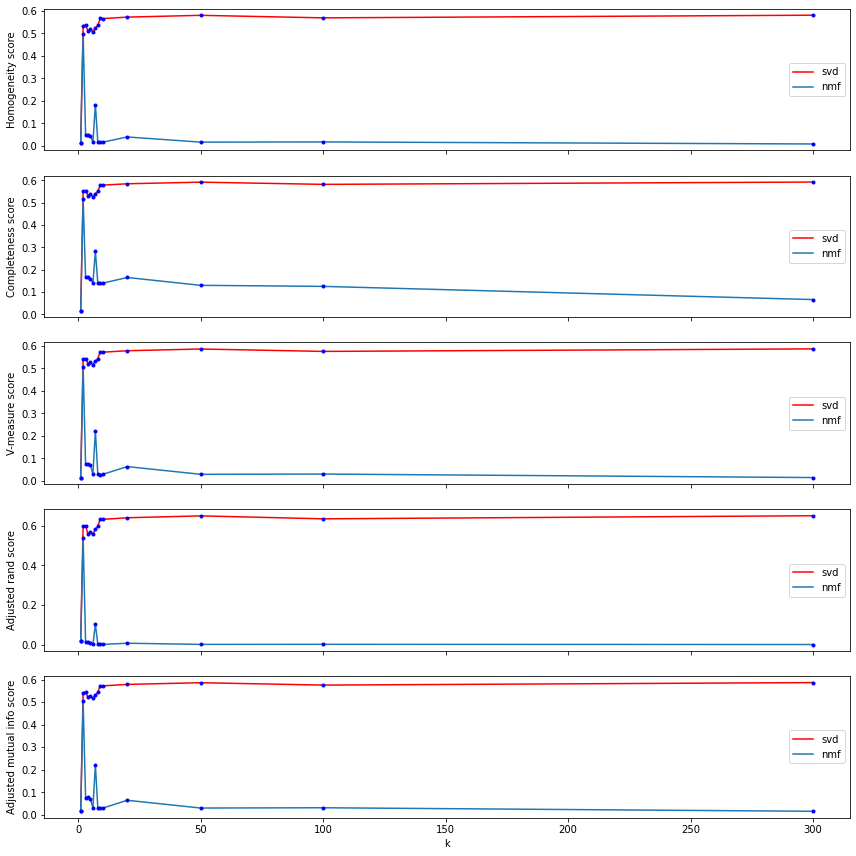

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 
                                              sharex=True,
                                              figsize=(12, 12 )
                                              )


ax1.plot(k, h_svd, color='r', label ='svd'), ax1.plot(k, h_svd, 'bo', markersize = 3)

ax1.plot(k, h_nmf, label ='nmf'), ax1.plot(k, h_nmf, 'bo', markersize = 3)

ax1.set(ylabel="Homogeneity score")
ax1.legend()

ax2.plot(k, c_svd, color='r', label ='svd'), ax2.plot(k, c_svd, 'bo', markersize = 3)

ax2.plot(k, c_nmf, label ='nmf'), ax2.plot(k, c_nmf, 'bo', markersize = 3)

ax2.set(ylabel="Completeness score")
ax2.legend()


ax3.plot(k, v_svd, color='r', label ='svd'), ax3.plot(k, v_svd, 'bo', markersize = 3)

ax3.plot(k, v_nmf, label ='nmf'), ax3.plot(k, v_nmf, 'bo', markersize = 3)

ax3.set(ylabel="V-measure score")
ax3.legend()



ax4.plot(k, adj_r_svd, color='r', label ='svd'), ax4.plot(k, adj_r_svd, 'bo', markersize = 3)

ax4.plot(k, adj_r_nmf, label ='nmf'), ax4.plot(k, adj_r_nmf, 'bo', markersize = 3)

ax4.set(ylabel="Adjusted rand score")
ax4.legend()


ax5.plot(k, adj_mi_svd, color='r', label ='svd'), ax5.plot(k, adj_mi_svd, 'bo', markersize = 3)

ax5.plot(k, adj_mi_nmf, label ='nmf'), ax5.plot(k, adj_mi_nmf, 'bo', markersize = 3)

ax5.set(ylabel="Adjusted mutual info score")
ax5.legend()


plt.xlabel('k')


fig.tight_layout()

In [ ]:
# average score

avg_svd = []
avg_nmf = []
for i in range(len(k)):
  avg_svd.append((h_svd[i] + c_svd[i] + v_svd[i] + adj_r_svd[i] + adj_mi_svd[i])/5)
  avg_nmf.append((h_nmf[i] + c_nmf[i] + v_nmf[i] + adj_r_nmf[i] + adj_mi_nmf[i])/5)



for i in range (len(avg_svd)):
  if avg_svd[i] == max(avg_svd):
    gamma = k[i]
    print("The optimal gamma for SVD is :", gamma ,"\nAverage score is: " ,avg_svd[i])

print("\n")

for i in range (len(avg_nmf)):
  if avg_nmf[i] == max(avg_nmf):
    gamma = k[i]
    print("The optimal gamma for NMF is :", gamma ,"\nAverage score is: " ,avg_svd[i])



The optimal gamma for SVD is : 300 
Average score is:  0.5993380312319259


The optimal gamma for NMF is : 2 
Average score is:  0.5531579294756476


In [ ]:
#SVD gamma=300
print('#' * 20)
print("Homogeneity score is: ", h_svd[13])

print("Completeness score is: ", c_svd[13])

print("V-measure score is: ", v_svd[13])

print("Adjusted rand score is: ", adj_r_svd[13])

print("Adjusted mutual info score is: ", adj_mi_svd[13])

print('#' * 20)
print("\n")

print('#' * 20)
#NMF gamma=2
print("Homogeneity score is: ", h_nmf[1])

print("Completeness score is: ", c_nmf[1])

print("V-measure score is: ", v_nmf[1])

print("Adjusted rand score is: ", adj_r_nmf[1])

print("Adjusted mutual info score is: ", adj_mi_nmf[1])

print('#' * 20)

####################
Homogeneity score is:  0.5806135302171918
Completeness score is:  0.5923574831989338
V-measure score is:  0.586426715642444
Adjusted rand score is:  0.6509294230254073
Adjusted mutual info score is:  0.5863630040756529
####################


####################
Homogeneity score is:  0.4950453839087971
Completeness score is:  0.5174355469228464
V-measure score is:  0.5059928956174533
Adjusted rand score is:  0.5395035409494571
Adjusted mutual info score is:  0.505915879956075
####################


## Visualize the clusters

In [ ]:
#SVD
svd = TruncatedSVD(n_components=300, random_state=0)

X_svd = svd.fit_transform(X_tfidf)

kmeans_label_svd = kmeans.fit_predict(X_svd)



#NMF
nmf = NMF(n_components=2, init = 'random', random_state=0, max_iter=500) 

X_nmf = nmf.fit_transform(X_tfidf)

kmeans_label_nmf = kmeans.fit_predict(X_nmf)


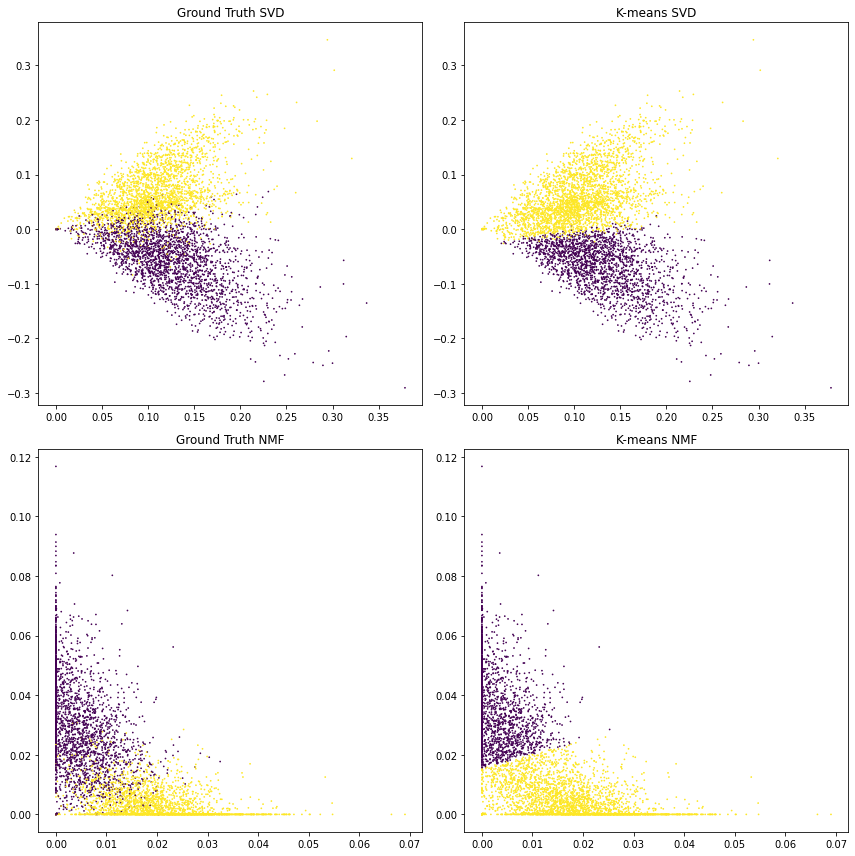

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,
                                        #sharey=True,
                                        figsize=(12, 12)
                                        )
x_svd = X_svd[:,0]
y_svd = X_svd[:,1]

ax1.scatter(x_svd, y_svd,s = 0.5, c = binary_label)
ax1.set(title = "Ground Truth SVD")

ax2.scatter(x_svd, y_svd,s = 0.5, c = kmeans_label_svd)
ax2.set(title = "K-means SVD")




x_nmf = X_nmf[:,0]
y_nmf = X_nmf[:,1]

ax3.scatter(x_nmf, y_nmf,s = 0.5, c = binary_label)
ax3.set(title = "Ground Truth NMF")

ax4.scatter(x_nmf, y_nmf,s = 0.5, c = kmeans_label_nmf)
ax4.set(title = "K-means NMF")


fig.tight_layout()

##Clustering of the Entire 20 Classes

In [ ]:
categories = ['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

newsgroups_entire_data = fetch_20newsgroups(categories = categories, 
                                     remove = ('headers', 'footers'))

entire_label = newsgroups_entire_data.target

In [ ]:
tfidfvector = TfidfVectorizer(min_df=3, stop_words='english')

X_entire_tfidf = tfidfvector.fit_transform(newsgroups_entire_data.data)

print("Dimensions of the TF-IDF is :", X_entire_tfidf.shape)

kmeans = KMeans(n_clusters=20, max_iter = 2000, n_init = 60, random_state=0)

kmeans_label_spare_tfidf = kmeans.fit_predict(X_entire_tfidf) 

print_eval_metrics("spare TF-IDF", entire_label, kmeans_label_spare_tfidf)

Dimensions of the TF-IDF is : (11314, 33551)
####################
Homogeneity score in spare TF-IDF transform is: 0.34810501531936705
Completeness score in spare TF-IDF transform is: 0.40067474927068214
V-measure score in spare TF-IDF transform is: 0.3725444952677556
Adjusted rand score in spare TF-IDF transform is: 0.12321219488700486
Adjusted mutual info score in spare TF-IDF transform is: 0.36889185403329405
####################


In [ ]:
##### running time around 4 min
# find optimal gamma SVD

kmeans = KMeans(n_clusters=20, max_iter = 2000, n_init = 60, random_state=0)

k = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]


h_svd = []

c_svd = []

v_svd = []

adj_r_svd = []

adj_mi_svd= []

for i in k:
    svd = TruncatedSVD(n_components=i, random_state=0)

    X_svd = svd.fit_transform(X_entire_tfidf)

    kmeans_label_svd = kmeans.fit_predict(X_svd)

    h_svd.append(homogeneity_score(entire_label, kmeans_label_svd)) 

    c_svd.append(completeness_score(entire_label, kmeans_label_svd))

    v_svd.append(v_measure_score(entire_label, kmeans_label_svd))

    adj_r_svd.append(adjusted_rand_score(entire_label, kmeans_label_svd))

    adj_mi_svd.append(adjusted_mutual_info_score(entire_label, kmeans_label_svd))


In [ ]:
##### running time around 33 mins
# find optimal gamma NMF
k = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]

kmeans = KMeans(n_clusters=20, max_iter = 2000, n_init = 60, random_state=0)

h_nmf = []

c_nmf = []

v_nmf = []

adj_r_nmf = []

adj_mi_nmf= []

entire_label = newsgroups_entire_data.target

for i in k:

    nmf = NMF(n_components=i, init = 'random', random_state=0, max_iter=500) 

    X_nmf = nmf.fit_transform(X_entire_tfidf)

    kmeans_label_nmf = kmeans.fit_predict(X_nmf)

    h_nmf.append(homogeneity_score(entire_label, kmeans_label_nmf)) 

    c_nmf.append(completeness_score(entire_label, kmeans_label_nmf))

    v_nmf.append(v_measure_score(entire_label, kmeans_label_nmf))

    adj_r_nmf.append(adjusted_rand_score(entire_label, kmeans_label_nmf))

    adj_mi_nmf.append(adjusted_mutual_info_score(entire_label, kmeans_label_nmf))

In [ ]:
# average score

avg_svd = []
avg_nmf = []
for i in range(len(k)):
  avg_svd.append((h_svd[i] + c_svd[i] + v_svd[i] + adj_r_svd[i] + adj_mi_svd[i])/5)
  avg_nmf.append((h_nmf[i] + c_nmf[i] + v_nmf[i] + adj_r_nmf[i] + adj_mi_nmf[i])/5)



for i in range (len(avg_svd)):
  if avg_svd[i] == max(avg_svd):
    gamma = k[i]
    print("The optimal gamma for SVD is :", gamma ,"\nAverage score is: " ,avg_svd[i])

print("\n")

for i in range (len(avg_nmf)):
  if avg_nmf[i] == max(avg_nmf):
    gamma = k[i]
    print("The optimal gamma for NMF is :", gamma ,"\nAverage score is: " ,avg_svd[i])



The optimal gamma for SVD is : 8 
Average score is:  0.3143949641210894


The optimal gamma for NMF is : 50 
Average score is:  0.30945779741202173


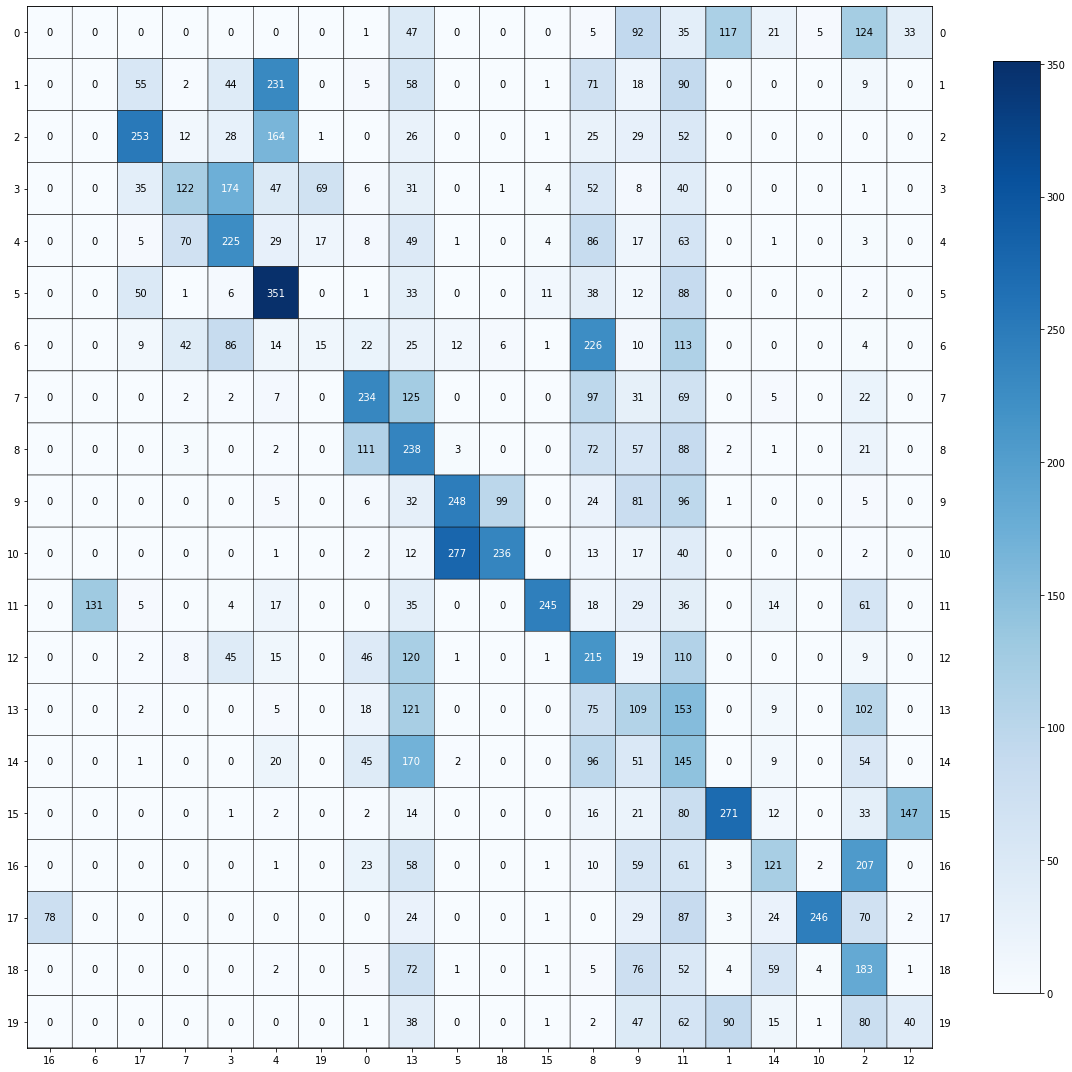

In [ ]:
# SVD
svd = TruncatedSVD(n_components=8, random_state=0)

X_svd = svd.fit_transform(X_entire_tfidf)

kmeans_label_svd = kmeans.fit_predict(X_svd)

cm = contingency_matrix(entire_label, kmeans_label_svd)


rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))


In [ ]:
print_eval_metrics("SVD", entire_label, kmeans_label_svd)

####################
Homogeneity score in SVD transform is: 0.34356185740291545
Completeness score in SVD transform is: 0.3752679359730747
V-measure score in SVD transform is: 0.3587156522858008
Adjusted rand score in SVD transform is: 0.13936178731937282
Adjusted mutual info score in SVD transform is: 0.3550675876242833
####################


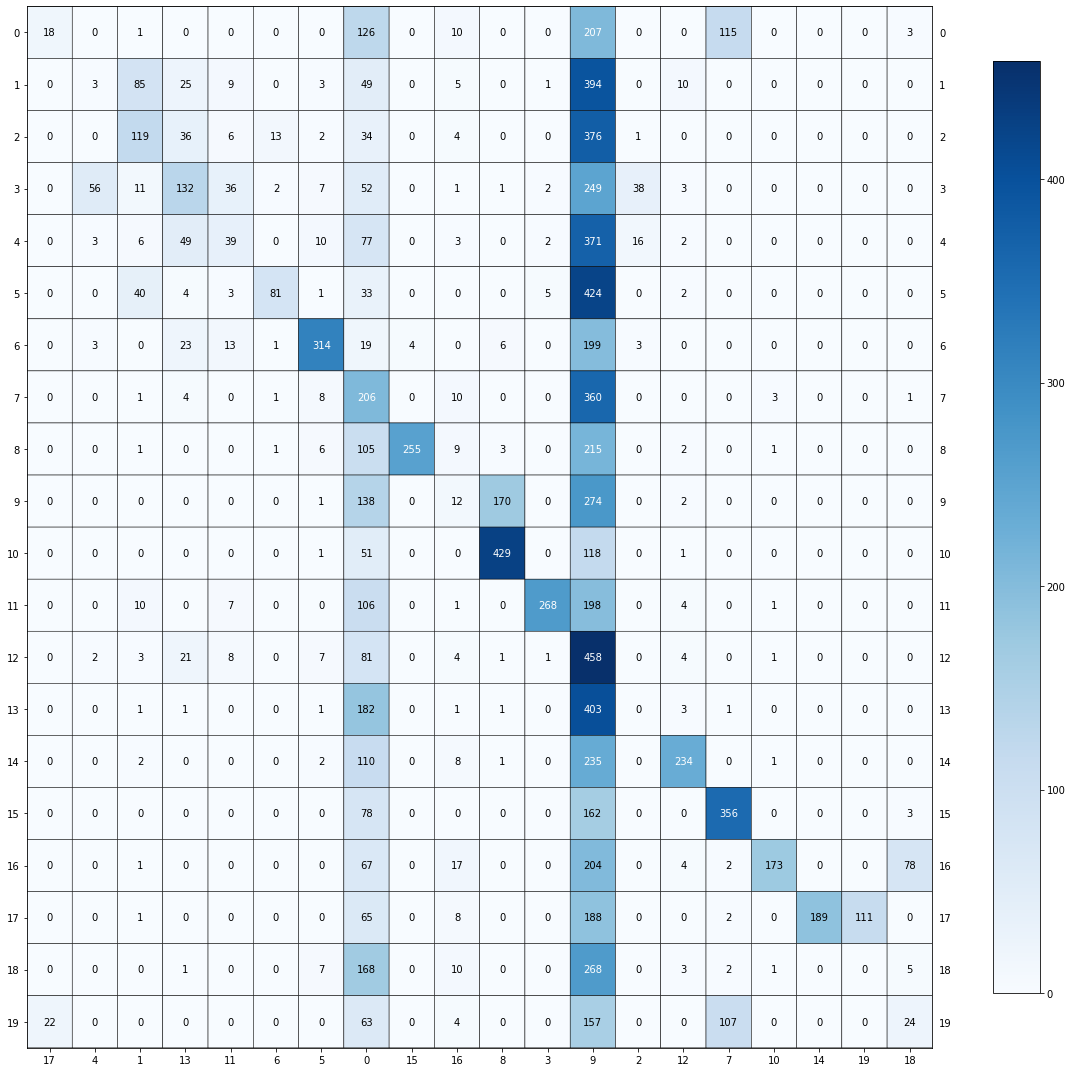

In [ ]:
# NMF
nmf = NMF(n_components=50, init = 'random', random_state=0, max_iter=500) 

X_nmf = nmf.fit_transform(X_entire_tfidf)

kmeans_label_nmf = kmeans.fit_predict(X_nmf)

cm = contingency_matrix(entire_label, kmeans_label_nmf)


rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))


In [ ]:
print_eval_metrics("NMF", entire_label, kmeans_label_nmf)

####################
Homogeneity score in NMF transform is: 0.2760010367197732
Completeness score in NMF transform is: 0.42097610555511633
V-measure score in NMF transform is: 0.33341076635089767
Adjusted rand score in NMF transform is: 0.05119369194370699
Adjusted mutual info score in NMF transform is: 0.32892904653461336
####################


## UMAP

In [ ]:
### define parameters
n_components_list = [5, 20, 200]
metrics_list = ['cosine', 'euclidean']
kmeans = KMeans(n_clusters=20, max_iter = 2000, n_init = 60, random_state=0)

# data: X_entire_tfidf, n_components = [5, 20, 200], metric = ['cosine', 'euclidean']
def reduce_dim_umap(data, n_components, metric):
  reducer = UMAP(n_components, metric=metric)
  X_umap = reducer.fit_transform(data)

  return X_umap

def kmeans_clustering(X, print_metrics, print_contingency_matrix):
  kmeans_label_umap = kmeans.fit_predict(X)

  if (print_contingency_matrix):
    cm = contingency_matrix(entire_label, kmeans_label_umap)
    rows, cols = linear_sum_assignment(cm, maximize=True)
    plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

  if (print_metrics):
    print_eval_metrics("UMAP", entire_label, kmeans_label_umap)

n_components: 5
metric: cosine


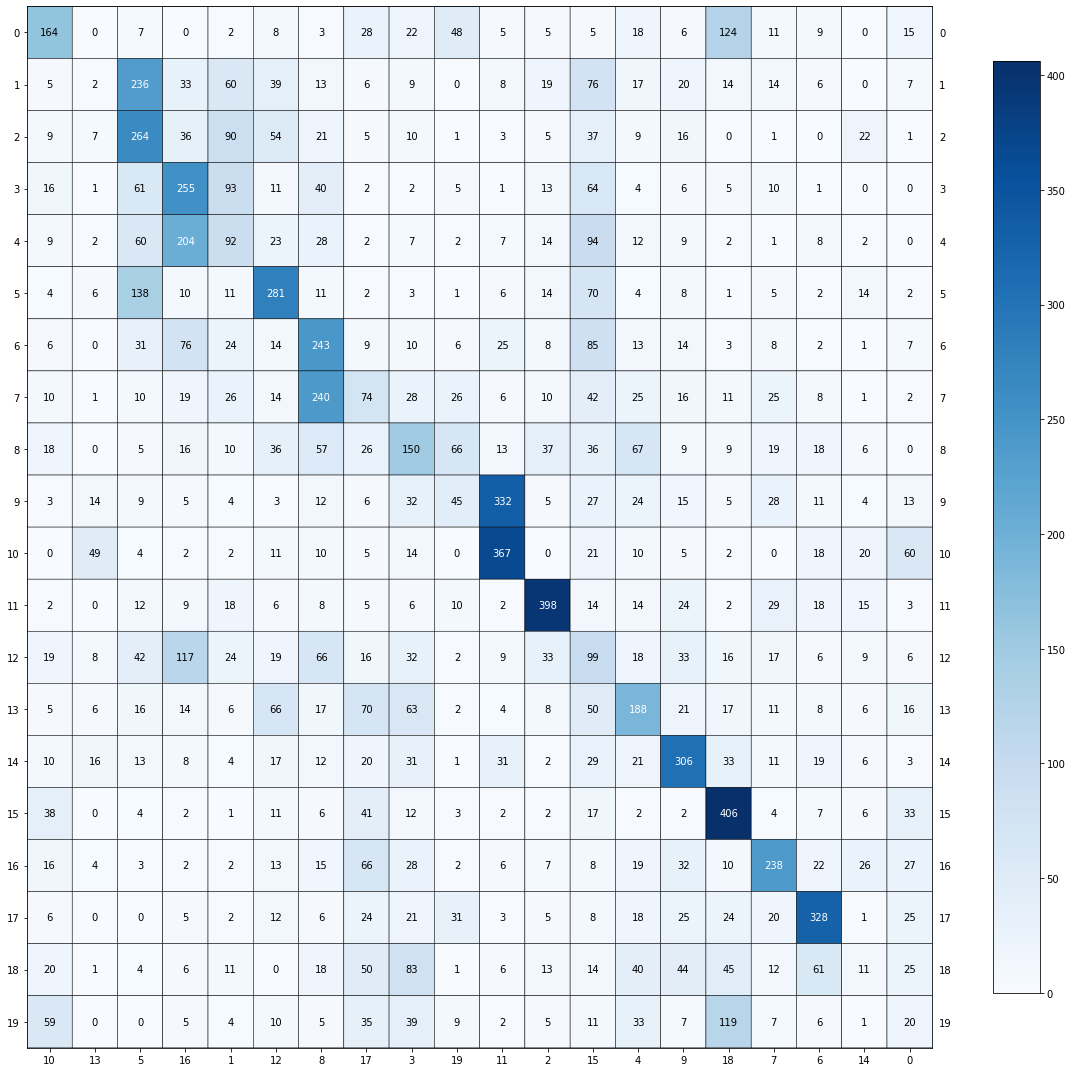

####################
Homogeneity score in UMAP transform is: 0.2983708343523569
Completeness score in UMAP transform is: 0.3077661934274848
V-measure score in UMAP transform is: 0.3029956980346728
Adjusted rand score in UMAP transform is: 0.19004413449001392
Adjusted mutual info score in UMAP transform is: 0.2991603949958133
####################
n_components: 20
metric: cosine


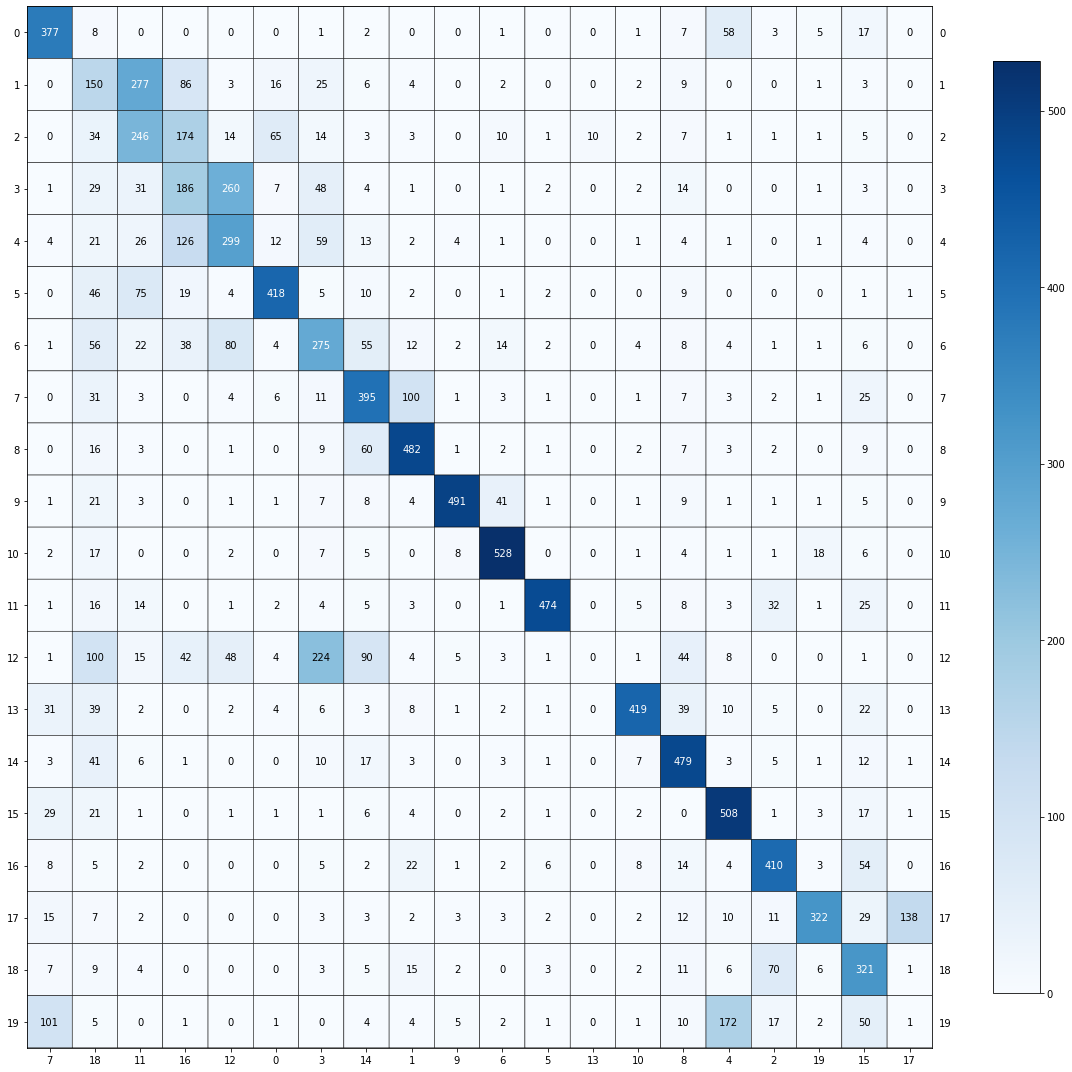

####################
Homogeneity score in UMAP transform is: 0.5690515695558347
Completeness score in UMAP transform is: 0.5845996819745939
V-measure score in UMAP transform is: 0.5767208524208152
Adjusted rand score in UMAP transform is: 0.4379381019723545
Adjusted mutual info score in UMAP transform is: 0.5743989690922022
####################
n_components: 200
metric: cosine


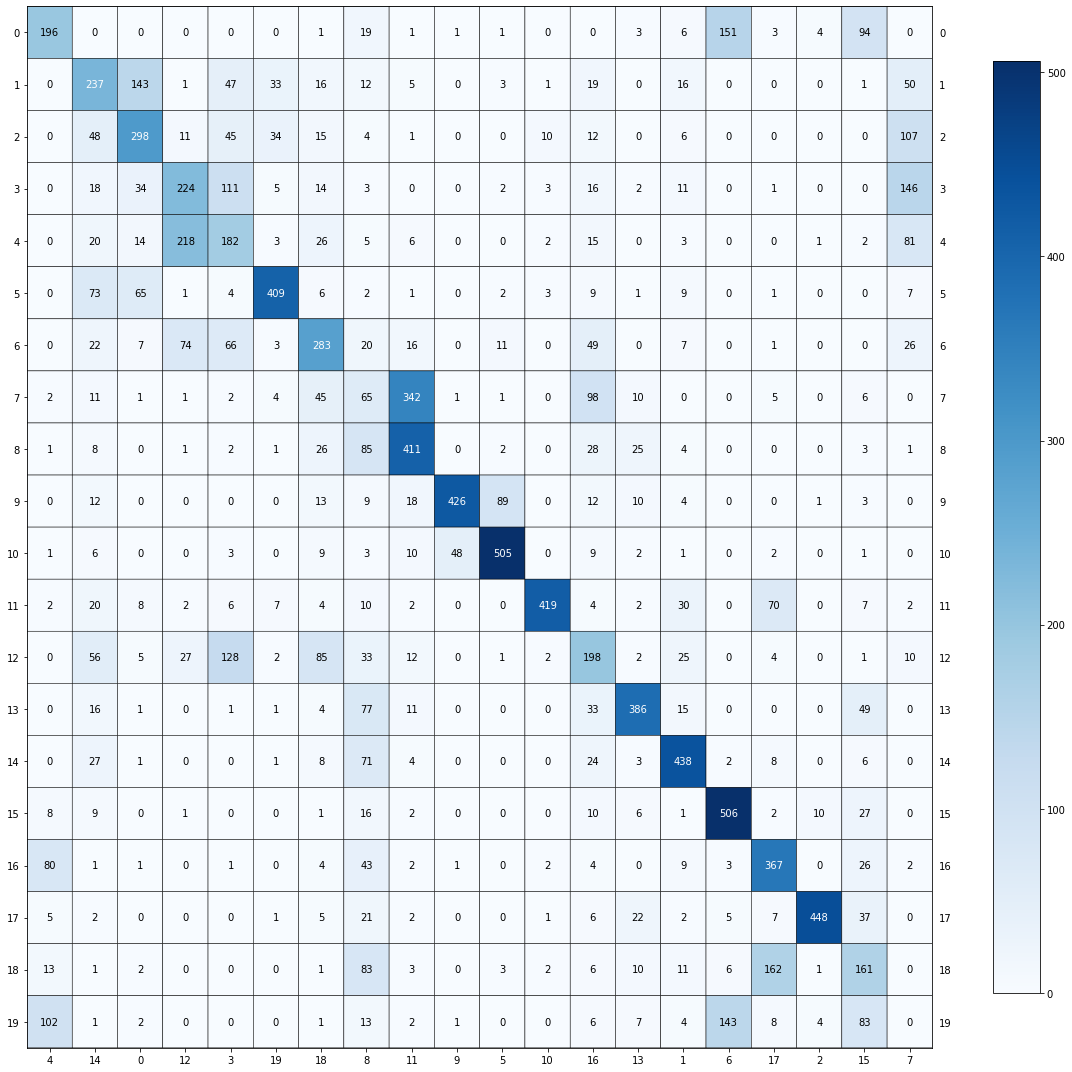

####################
Homogeneity score in UMAP transform is: 0.5513410878433894
Completeness score in UMAP transform is: 0.5536693890646068
V-measure score in UMAP transform is: 0.5525027855421525
Adjusted rand score in UMAP transform is: 0.3914868972414067
Adjusted mutual info score in UMAP transform is: 0.550080293656161
####################
n_components: 5
metric: euclidean


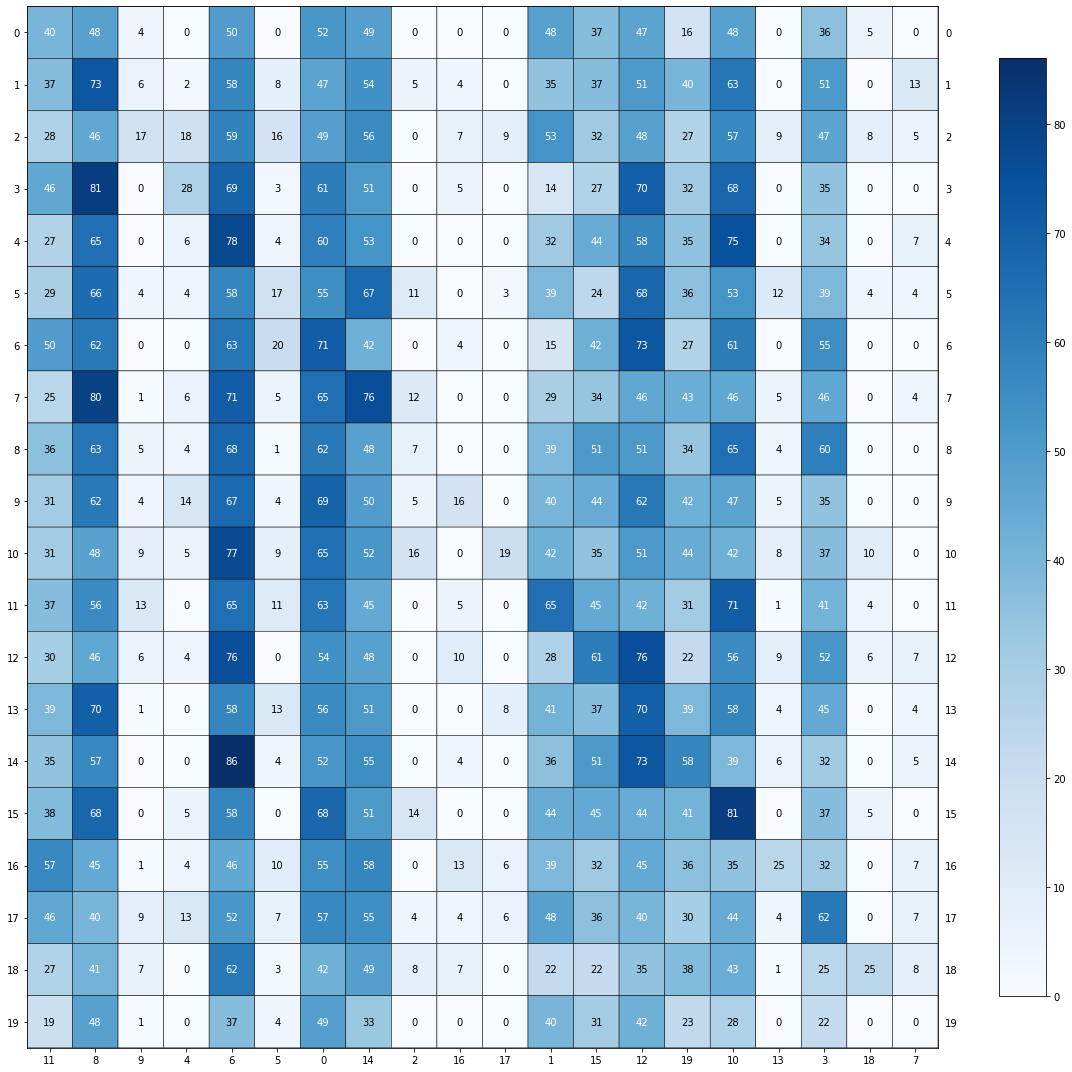

####################
Homogeneity score in UMAP transform is: 0.023265352900439965
Completeness score in UMAP transform is: 0.02663158359782909
V-measure score in UMAP transform is: 0.02483491910260087
Adjusted rand score in UMAP transform is: 0.0019241152228455765
Adjusted mutual info score in UMAP transform is: 0.01905798778458872
####################
n_components: 20
metric: euclidean


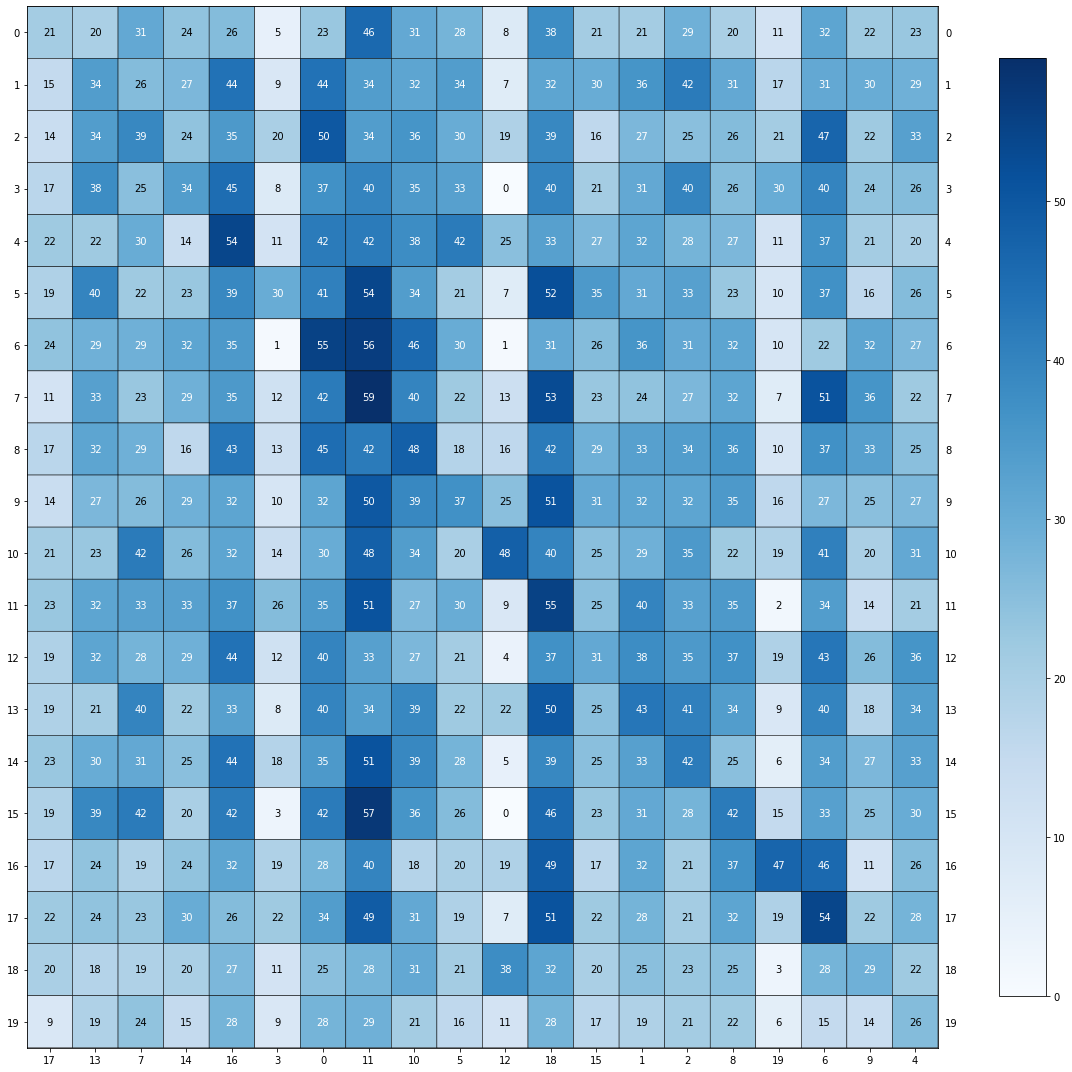

####################
Homogeneity score in UMAP transform is: 0.011958463029229751
Completeness score in UMAP transform is: 0.012134439335973994
V-measure score in UMAP transform is: 0.012045808510746362
Adjusted rand score in UMAP transform is: 0.001338165944514129
Adjusted mutual info score in UMAP transform is: 0.006665966118637846
####################
n_components: 200
metric: euclidean


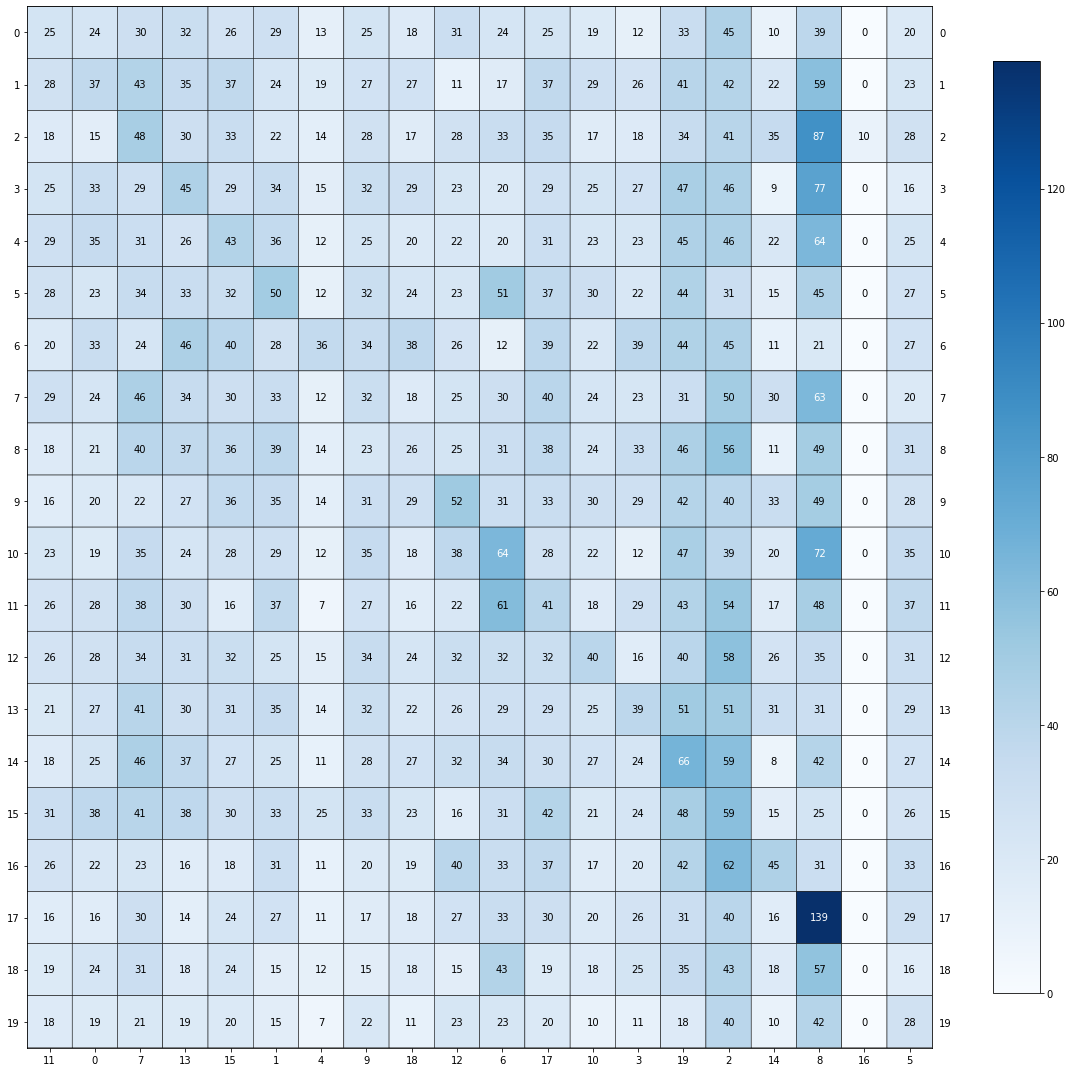

####################
Homogeneity score in UMAP transform is: 0.01379619817982503
Completeness score in UMAP transform is: 0.014207330525148568
V-measure score in UMAP transform is: 0.013998746343450295
Adjusted rand score in UMAP transform is: 0.003310914912882188
Adjusted mutual info score in UMAP transform is: 0.008586929633587762
####################


In [ ]:
for i in range(2):
  for j in range(3):
    print("n_components:", n_components_list[j])
    print("metric:", metrics_list[i])
    X_umap = reduce_dim_umap(X_entire_tfidf, n_components_list[j], metrics_list[i])
    kmeans_clustering(X_umap, True, True)

# Clustering Algorithms that Do Not Explicitly Rely on the Gaussian Distribution Per Cluste

## Agglomerative Clustering (TODO: check optimal parameters)

In [ ]:
# n_clusters = 20, linkage_criterias = 'ward' / 'single'
linkages = ['ward', 'single']

def agglomerative_clustering(X, n_clusters, linkage, print_metrics):
  # UMAP use n_components=20, metric='cosine' from previous part
  agglomerative_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
  agglomerative_label_umap = agglomerative_cluster.fit_predict(X)

  if (print_metrics):
    print_eval_metrics("UMAP with agglomerative clustering", entire_label, agglomerative_label_umap)

In [ ]:
X_umap = reduce_dim_umap(data=X_entire_tfidf, n_components=20, metric='cosine')

for i in range(2):
  print("linkage:", linkages[i])
  agglomerative_clustering(X_umap, n_clusters=20, linkage=linkages[i],print_metrics=True)

####################
Homogeneity score in UMAP with agglomerative clustering transform is: 0.5426632915800996
Completeness score in UMAP with agglomerative clustering transform is: 0.5739911022267402
V-measure score in UMAP with agglomerative clustering transform is: 0.5578877450348046
Adjusted rand score in UMAP with agglomerative clustering transform is: 0.40201854448225194
Adjusted mutual info score in UMAP with agglomerative clustering transform is: 0.5554071004883744
####################
####################
Homogeneity score in UMAP with agglomerative clustering transform is: 0.10724228088667982
Completeness score in UMAP with agglomerative clustering transform is: 0.6733207858585607
V-measure score in UMAP with agglomerative clustering transform is: 0.1850163296733359
Adjusted rand score in UMAP with agglomerative clustering transform is: 0.02033546495900337
Adjusted mutual info score in UMAP with agglomerative clustering transform is: 0.17921225565596471
####################


## HDBSCAN

In [ ]:
min_cluster_size = [20, 100, 200]

def HDSCAN_clustering(X, min_cluster_size, print_metrics):
  hdbscan_cluster = HDBSCAN(min_cluster_size)
  hdbscan_label_umap = hdbscan_cluster.fit_predict(X)

  if (print_metrics):
    print_eval_metrics("UMAP with HDBSCAN clustering", entire_label, hdbscan_label_umap)
  
  return hdbscan_label_umap

def plot_contingency_matrix(entire_labels, predicted_labels):
  cm = contingency_matrix(entire_labels, predicted_labels)
  rows, cols = linear_sum_assignment(cm, maximize=True)
  plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(10,10))

In [ ]:
X_umap = reduce_dim_umap(data=X_entire_tfidf, n_components=20, metric='cosine')

for i in range(3):
  print("min_cluster_size: ", min_cluster_size[i])
  HDSCAN_clustering(X_umap, min_cluster_size[i], True)

min_cluster_size:  20
####################
Homogeneity score in UMAP with HDSCAN clustering transform is: 0.47563093913794796
Completeness score in UMAP with HDSCAN clustering transform is: 0.48957818516056606
V-measure score in UMAP with HDSCAN clustering transform is: 0.48250379348331796
Adjusted rand score in UMAP with HDSCAN clustering transform is: 0.14238518342488432
Adjusted mutual info score in UMAP with HDSCAN clustering transform is: 0.47219097315806624
####################
min_cluster_size:  100
####################
Homogeneity score in UMAP with HDSCAN clustering transform is: 0.40775769202659995
Completeness score in UMAP with HDSCAN clustering transform is: 0.5928685503014677
V-measure score in UMAP with HDSCAN clustering transform is: 0.4831908289425474
Adjusted rand score in UMAP with HDSCAN clustering transform is: 0.17748064352787035
Adjusted mutual info score in UMAP with HDSCAN clustering transform is: 0.48109285607204477
####################
min_cluster_size:  200


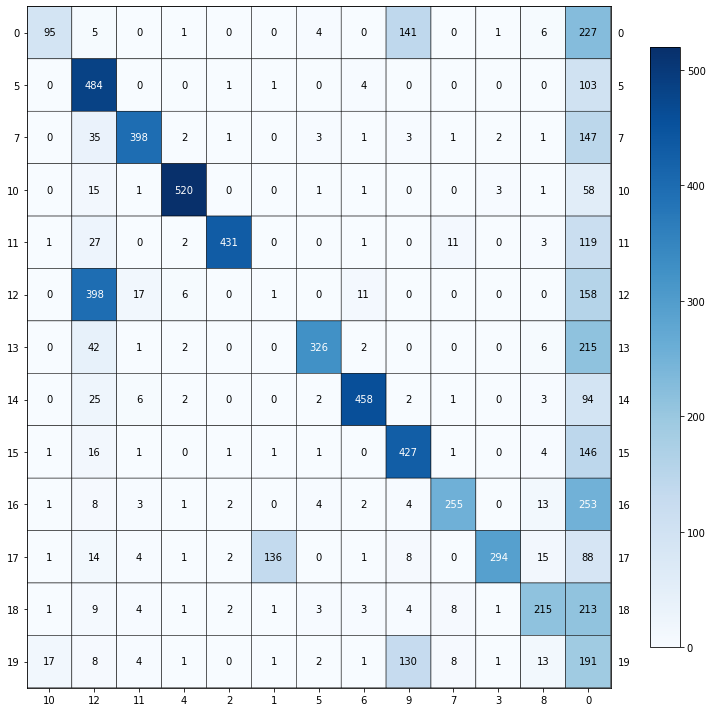

In [ ]:
hdbscan_label_umap = HDSCAN_clustering(X_umap, min_cluster_size=100, print_metrics=False)
plot_contingency_matrix(entire_label, hdbscan_label_umap)

##Find Best Hyperparameters

In [ ]:
### use evaluation metrics to compare parameters

svd_5 = TruncatedSVD(n_components=5, random_state=0)
svd_20 = TruncatedSVD(n_components=20, random_state=0)
svd_200 = TruncatedSVD(n_components=200, random_state=0)

nmf_5 = NMF(n_components=5, init = 'random', random_state=0, max_iter=500)
nmf_20 = NMF(n_components=20, init = 'random', random_state=0, max_iter=500)
nmf_200 = NMF(n_components=200, init = 'random', random_state=0, max_iter=500)

umap_5 = UMAP(n_components=5, metric='cosine')
umap_20 = UMAP(n_components=20, metric='cosine')
umap_200 = UMAP(n_components=200, metric='cosine')

reducer = [svd_5, svd_20, svd_200, nmf_5, nmf_20, nmf_200, umap_5, umap_20, umap_200]
reducted_data_file = ["svd_5.pkl", "svd_20.pkl", "svd_200.pkl",
                      "nmf_5.pkl", "nmf_20.pkl", "nmf_200.pkl",
                      "umap_5.pkl", "umap_20.pkl", "umap_200.pkl"]

In [ ]:
for i in range(9):
  pickle.dump(reducer[i].fit_transform(X_entire_tfidf), open(reducted_data_file[i], 'wb'))

In [ ]:
kmeans_10 = KMeans(n_clusters=10,max_iter = 2000, n_init = 60, random_state=0)
kmeans_20 = KMeans(n_clusters=20,max_iter = 2000, n_init = 60, random_state=0)
kmeans_50 = KMeans(n_clusters=50,max_iter = 2000, n_init = 60, random_state=0)

agglomerative = AgglomerativeClustering(n_clusters=20, linkage='ward')

hdbscan_100 = HDBSCAN(min_cluster_size=100)
hdbscan_200 = HDBSCAN(min_cluster_size=200)

cluster = [kmeans_10, kmeans_20, kmeans_50, agglomerative, hdbscan_100, hdbscan_200]

In [ ]:
homogeneity_scores = []
completeness_scores = []
v_measure_scores = []
adjusted_rand_scores = []
adjusted_mutual_info_scores = []

for i in range(9):
  reduced_data = pickle.load(open(reducted_data_file[i], 'rb'))
  for j in range(6):
    labels = cluster[j].fit_predict(reduced_data)
    homogeneity_scores.append(homogeneity_score(entire_label, labels))
    completeness_scores.append(completeness_score(entire_label, labels))
    v_measure_scores.append(v_measure_score(entire_label, labels))
    adjusted_rand_scores.append(adjusted_rand_score(entire_label, labels))
    adjusted_mutual_info_scores.append(adjusted_mutual_info_score(entire_label, labels))

print(homogeneity_scores)
print(completeness_scores)
print(v_measure_scores)
print(adjusted_rand_scores)
print(adjusted_mutual_info_scores)

[0.25794562172465807, 0.3060357511980009, 0.3716739362564548, 0.305147897096495, 0.0, 0.0, 0.25732108294318395, 0.3375148402474223, 0.4491204075323829, 0.36299726053100245, 0.0, 0.0, 0.3075138257961867, 0.30437941412161157, 0.4343285345249788, 0.3254198278689902, 0.0, 0.0, 0.22391254956297346, 0.26015132757181064, 0.3047243516910712, 0.2660870449605571, 0.06852763299419164, 0.0, 0.21835485930921356, 0.291152557507311, 0.3821064347009431, 0.3320296263184351, 0.0, 0.0, 0.062486245223702504, 0.09793160529230578, 0.2406884901427669, 0.16935322701753697, 0.0, 0.0, 0.48022039727638055, 0.5765881506582439, 0.6249757857516343, 0.5653871944366367, 0.3779952142783231, 0.3855728368629968, 0.47650029845755765, 0.574787531004105, 0.6235219789156698, 0.55802406850508, 0.3789656158349508, 0.33023568535206177, 0.4768764421757267, 0.57914885144875, 0.6330014351468863, 0.5634084752015127, 0.3395664428824843, 0.32417469048994]
[0.39154409248466043, 0.33329979180600805, 0.2999825009820571, 0.3359952904589

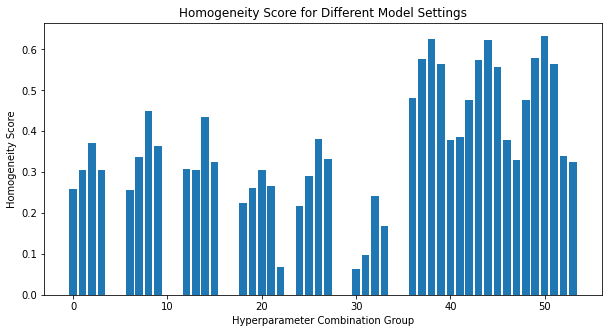

In [ ]:
plt.bar(range(54), homogeneity_scores)
plt.title("Homogeneity Score for Different Model Settings")
plt.xlabel("Hyperparameter Combination Group")
plt.ylabel("Homogeneity Score")
plt.show()

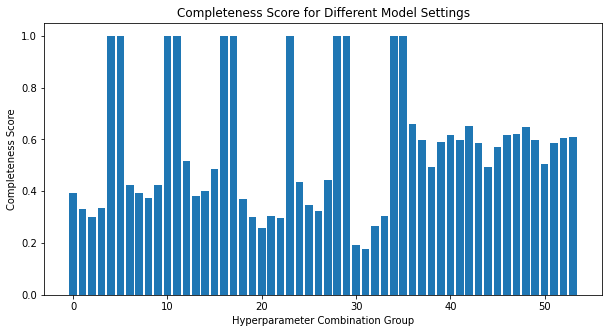

In [ ]:
plt.bar(range(54), completeness_scores)
plt.title("Completeness Score for Different Model Settings")
plt.xlabel("Hyperparameter Combination Group")
plt.ylabel("Completeness Score")
plt.show()

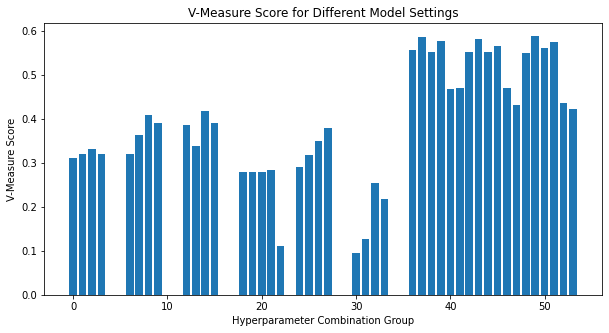

In [ ]:
plt.bar(range(54), v_measure_scores)
plt.title("V-Measure Score for Different Model Settings")
plt.xlabel("Hyperparameter Combination Group")
plt.ylabel("V-Measure Score")
plt.show()

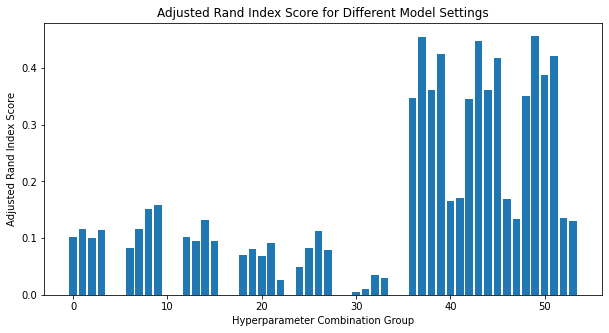

In [ ]:
plt.bar(range(54), adjusted_rand_scores)
plt.title("Adjusted Rand Index Score for Different Model Settings")
plt.xlabel("Hyperparameter Combination Group")
plt.ylabel("Adjusted Rand Index Score")
plt.show()

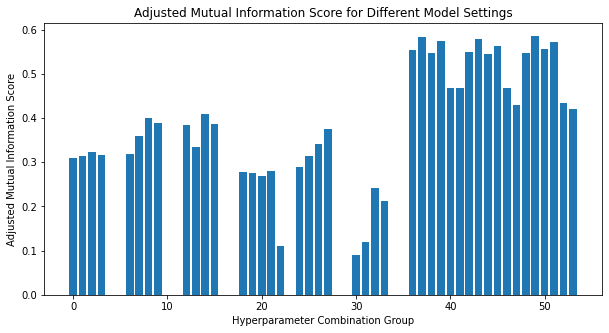

In [ ]:
plt.bar(range(54), adjusted_mutual_info_scores)
plt.title("Adjusted Mutual Information Score for Different Model Settings")
plt.xlabel("Hyperparameter Combination Group")
plt.ylabel("Adjusted Mutual Information Score")
plt.show()

# Part 2. Deep Learning and Clustering of Image Data

## Clustering and Dimentional Reduction Method from Table

Feature Extraction (from helper code)

In [ ]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

100%|██████████| 58/58 [00:41<00:00,  1.41it/s]


T-SNE Plot

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


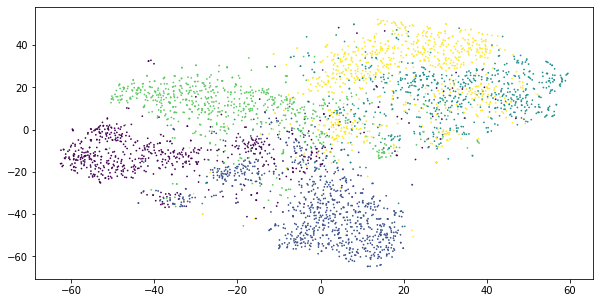

In [ ]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

data = np.load('flowers_features_and_labels.npz')

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(data['f_all'])
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s = 0.5, c = data['y_all'])
plt.show()

Autoencoder Definition (from helper code)

In [ ]:
class Autoencoder(torch.nn.Module, TransformerMixin, BaseEstimator):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

Best Results From Table, Q24

In [ ]:
#setup
X_train, X_test, y_train, y_test = train_test_split(data["f_all"],data["y_all"], test_size=0.2)
X = data["f_all"]
y = data["y_all"]

X_svd = TruncatedSVD(n_components=50, random_state=0).fit_transform(X)
X_umap = UMAP(n_components=50, metric = 'cosine').fit_transform(X)
X_autoencoder = Autoencoder(100).fit_transform(X)

100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


In [ ]:
#None and KMeans
kmeans = KMeans(n_clusters=5).fit(X)
label_none_kmeans = kmeans.labels_
None_Kmeans = adjusted_rand_score(y, label_none_kmeans)


#None and Agglomerative
agglomerative = AgglomerativeClustering(n_clusters = 5, linkage='ward').fit(X)
label_none_agglomerative = agglomerative.labels_
None_Agglomerative = adjusted_rand_score(y, label_none_agglomerative)


# #None and HDBSCAN
# hdbscan_clustering = hdbscan.HDBSCAN(min_cluster_size=5, prediction_data=True).fit(X)
# label_none_hdbscan = hdbscan_clustering.labels_
# print('None&HDBSCAN: ', adjusted_rand_score(y, label_none_hdbscan))


#SVD and KMeans
kmeans = KMeans(n_clusters=5).fit(X_svd)
label_svd_kmeans = kmeans.labels_
SVD_Kmeans = adjusted_rand_score(y, label_svd_kmeans)


#SVD and Agglomerative
agglomerative = AgglomerativeClustering(n_clusters = 5, linkage='ward').fit(X_svd)
label_svd_agglomerative = agglomerative.labels_
SVD_Agglomerative = adjusted_rand_score(y, label_svd_agglomerative)



# #SVD and HDBSCAN
# hdbscan_clustering = HDBSCAN(min_cluster_size=5, min_samples=1, prediction_data=True).fit_predict(X_svd)
# label_svd_hdbscan = hdbscan_clustering.labels_
# print('SVD&HDBSCAN: ', adjusted_rand_score(y, label_svd_hdbscan))

#UMAP and KMeans
kmeans = KMeans(n_clusters=5).fit(X_umap)
label_umap_kmeans = kmeans.labels_
UMAP_Kmeans = adjusted_rand_score(y, label_umap_kmeans)


#UMAP and Agglomerative
agglomerative = AgglomerativeClustering(n_clusters = 5, linkage='ward').fit(X_umap)
label_umap_agglomerative = agglomerative.labels_
UMAP_Agglomerative = adjusted_rand_score(y, label_umap_agglomerative)


# #UMAP and HDBSCAN
# hdbscan_clustering = HDBSCAN(min_cluster_size=5, min_samples=1, prediction_data=True).fit(X_umap)
# label_umap_hdbscan = hdbscan_clustering.labels_
# print('UMAP&HDBSCAN: ', adjusted_rand_score(y, label_umap_hdbscan))


#Autoencoder and KMeans
kmeans = KMeans(n_clusters=5).fit(X_autoencoder)
label_autoencoder_kmeans = kmeans.labels_
Autoencoder_KMeans = adjusted_rand_score(y, label_autoencoder_kmeans)


#Autoencoder and Agglomerative
agglomerative = AgglomerativeClustering(n_clusters = 5, linkage='ward').fit(X_autoencoder)
label_autoencoder_agglomerative = agglomerative.labels_
Autoencoder_Agglomerative = adjusted_rand_score(y, label_autoencoder_agglomerative)


# #Autoencoder and HDBSCAN
# hdbscan_clustering = HDBSCAN(min_cluster_size=5, min_samples=1, prediction_data=True).fit(X_autoencoder)
# label_autoencoder_hdbscan = hdbscan_clustering.labels_
# print('Autoencoder&HDBSCAN: ', adjusted_rand_score(y, label_autoencoder_hdbscan))

GridSearch for HDBSCAN

In [ ]:
#sklearn GridSearchCV does not work for HDBSCAN



# hdbscan_ = hdbscan.HDBSCAN()

# param_grid = {
#     'min_cluster_size': [2, 3, 5, 20, 100],
#     'min_samples': [1, 2, 5, 10,20],
# }

# hdbscan_model = hdbscan.HDBSCAN()
# grid_search = GridSearchCV(hdbscan_model, param_grid, scoring='rand_score')

# grid_search.fit(X_umap, y)
# best_hdbscan = grid_search.best_estimator_
# best_parameters = grid_search.best_params_
# cluster_labels = best_hdbscan.fit_predict(X_umap)

# print(best_parameters)
# print_eval_metrics("Gridsearch HDBSCAN", y, cluster_labels)


In [ ]:
from tabulate import tabulate

input = [X, X_svd, X_umap, X_autoencoder]

cluster_size = [5, 20, 100]
samples = [1, 5, 10]


hdbscan_bestscore = [0,0,0,0]
best_min_cluster_size = [0,0,0,0]
best_min_samples=min_samples = [0,0,0,0]



for k in range(len(input)):
  for i in range(len(cluster_size)):
    for j in range(len(samples)):
      #print("min_cluster_size: ", min_cluster_size[i], min_samples[j])
      #HDBSCAN_clustering(X_umap, min_cluster_size[i], min_samples[j], True)
      hdbscan_cluster = HDBSCAN(min_cluster_size=cluster_size[i], min_samples=samples[j])
      hdbscan_label = hdbscan_cluster.fit_predict(input[k])
      #print_eval_metrics("UMAP with HDSCAN clustering", y, hdbscan_label_umap)
      if adjusted_rand_score(y,hdbscan_label) > hdbscan_bestscore[k] :
        hdbscan_bestscore[k] = adjusted_rand_score(y,hdbscan_label)
        best_min_cluster_size[k] = cluster_size[i]
        best_min_samples[k] = samples[j]
          

In [ ]:
None_HDBSCAN = hdbscan_bestscore[0]
SVD_HDBSCAN = hdbscan_bestscore[1]
UMAP_HDBSCAN = hdbscan_bestscore[2]
Autoencoder_HDBSCAN = hdbscan_bestscore[3]

col_names = ["HDBSCAN_Parameters", "min_cluster_size", "min_samples", "adjusted_rand_score"]

data = [["None_HDBSCAN",best_min_cluster_size[0], best_min_samples[0], None_HDBSCAN],
        ["SVD_HDBSCAN",best_min_cluster_size[1], best_min_samples[1], SVD_HDBSCAN],
        ["UMAP_HDBSCAN",best_min_cluster_size[2], best_min_samples[2], UMAP_HDBSCAN],
        ["Autoencoder_HDBSCAN",best_min_cluster_size[3], best_min_samples[3], Autoencoder_HDBSCAN]]


  
print(tabulate(data, headers=col_names))

HDBSCAN_Parameters      min_cluster_size    min_samples    adjusted_rand_score
--------------------  ------------------  -------------  ---------------------
None_HDBSCAN                           5              1              0.014983
SVD_HDBSCAN                           20              1              0.0280682
UMAP_HDBSCAN                           5              1              0.18618
Autoencoder_HDBSCAN                    5              1              0.0186734


In [ ]:
col_names = ["K-Means", "Agglomerative", "HDBSCAN"]

data = [["None", None_Kmeans, None_Agglomerative, None_HDBSCAN],
        ["SVD", SVD_Kmeans, SVD_Agglomerative, SVD_HDBSCAN],
        ["UMAP", UMAP_Kmeans, UMAP_Agglomerative, UMAP_HDBSCAN],
        ["Autoencoder", Autoencoder_KMeans, Autoencoder_Agglomerative, Autoencoder_HDBSCAN]]

print(tabulate(data, headers=col_names)) 

               K-Means    Agglomerative    HDBSCAN
-----------  ---------  ---------------  ---------
None          0.191741         0.188553  0.014983
SVD           0.196105         0.184339  0.0280682
UMAP          0.466324         0.476011  0.18618
Autoencoder   0.225285         0.264014  0.0186734


## MLP on VGG

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                optimizer.zero_grad()

                output = self(X_)
                loss = criterion(output, y_)

                
                loss.backward()
                optimizer.step()
                ##################################
                
                #raise NotImplementedError
        return self
    
    def eval(self, X, y):
        ##################################
        self.model.eval()

        num_correct = 0
        
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        output = self(X)
        _, predictions = torch.max(output, 1)

        #print(predictions)
        #print(y)
        num_correct += torch.sum(predictions == y)
        num_examples = len(y)
        accuracy = num_correct / num_examples
        ##############################

        #raise NotImplementedError
        return accuracy

In [ ]:
# testing original dataset
X_train, X_test, y_train, y_test = train_test_split(data["f_all"],data["y_all"], test_size=0.2)


MLP_classification = MLP(num_features = 4096).train(X_train, y_train)
MLP_classification.eval(X_test,y_test)

100%|██████████| 100/100 [00:08<00:00, 11.56it/s]


tensor(0.9060, device='cuda:0')

In [ ]:
# testing dimensionally reduced dataset
X_umap = UMAP(n_components=50, metric = 'cosine').fit_transform(X)

X_train_umap, X_test_umap, y_train, y_test = train_test_split(X_umap,y, test_size=0.2)

#X_test_autoencoder = Autoencoder(50).fit_transform(X_test)

MLP_classification = MLP(num_features = 50).train(X_train_umap, y_train)
MLP_classification.eval(X_test_umap,y_test)



100%|██████████| 100/100 [00:06<00:00, 15.17it/s]


tensor(0.8392, device='cuda:0')